In [7]:
# Numpy will be used for matrix and vector
# operations, as well as for some of our 
# sampling.
import numpy as np
# used for some of our sampling
import random
random.seed();
# We will use metrics from sklearn to 
# make our confusion matrix
from sklearn import metrics
# plt will be used to make our plots
from matplotlib import pyplot as plt
# This is used to make copies of objects
# copying an object is not the same thing as
# reassignin an object
import copy

In [8]:
# The following packages will be used to get useful pretrained
# features for our explicit nonlinear transformation from the
# image space to a feature space designed hopefully to assist
# in image classification. We chose to use the Xception convolutional
# neural network due to its relatively small size (88 million parameters)
# but great performance compared to other networks of its size
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input as prepro1
# This is the pretrained model we will use for our useful features. The top layer
# is the layer that returns imagenet classifications, we will omit this layer as
# we are not interested in imagenet classifications but we are instead interested
# in having a useful feature representation of our image.
model1 = Xception(weights='imagenet',include_top=False);
model3 = Xception(weights=None,include_top=False);
# Here is another model to try
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input as prepro2
model2 = DenseNet201(weights='imagenet',include_top=False);
model4 = DenseNet201(weights=None,include_top=False);

In [9]:
# A collection of kernel functions
# x, and y are assumed to be Matrices
# if you want to evaluate on a single point
# reshape the vectors from d to d x 1, this
# will turen them into matrices. All the kernel
# functions work with vectors or matrices with the
# exception of k5v which requires matrices as inputs.
# and k7v which also requires matrices.

# Linear kernel, notice, if x, and y
# are vectors, this will return a scalar
# if x, and y are matrices, this will 
# return a matrix and this is an efficient
# and vectorized implementation of the linear
# kernel function.
def k1v(x,y):
    # np.dot computes the vector dot
    # product if x, and y are vectors
    # or it computes the matrix product
    # of x and y, if x or y are matrices
    return (np.dot(x,y.T))

# Affine kernel. Again, if x and y are 
# vectors, this will return a scalar but
# if x, and y are matrices this is a vectorized
# version of the affine kernel.
def k2v(x,y):
    return (np.dot(x,y.T)+1)

# Quadratic kernel. Again, if x and y are 
# vectors, this will return a scalar but
# if x, and y are matrices this is a vectorized
# version of the quadratic kernel.
def k3v(x,y):
    # To raise a number by a power python
    # uses ** instead of ^, ^ is reserved
    # for bit operations. (and?)
    return ((1+np.dot(x,y.T))**2)

# dth order kernel
d = 4
def k4v(x,y):
    return ((1+np.dot(x,y.T))**d)

# Gaussian kernel. This is the only kernel function
# in this set of example kernels that is tricky to 
# efficiently vectorize. This is because to evaluate
# this kernel function, we have to evaluate (x-y)^T(x-y)
# whereas in all the other examples, we evaluate x^Ty
# Expanding (x-y)^T(x-y) gives us x^Tx - 2x^Ty + y^Ty
# So k(x_i,y_j) = e^(-(x_i-y_j)^T(x_i-y_j)/(2*sigma^2))
# So k(x_i,x_j) = f(x_i^Tx_i+y_j^Ty_j-2x_i^Ty_j)
# we get x_i^Ty_j using np.dot(X,Y) where X and Y are the
# X and Y data matrices respectively. We get x_i^Tx_i using
# np.sum(X*X,axis=1).reshape(d,1). This function requires 
# matrices and will fail if x, or y are vectors. It is
# vectorized and efficient. For any kernel function that uses
# k(x_i,x_j) = f((x_i-x_j)^T(x_i-x_j)) use the line that 
# computes XminusYSquared to compute the matrix whose i,jth 
# entry is (x_i-x_j)^T(x_i-x_j) in a vectorized and efficient
# manner. Then apply f(XminusYsquared).
sigma = 2**15;
def k5v(x,y):
    numxPoints = np.shape(x)[0];
    numyPoints = np.shape(y)[0];
    XminusYSquared =np.sum(x*x,axis=1).reshape([numxPoints,1])-2*np.dot(x,y.T)+np.sum(y*y,axis=1).reshape([1,numyPoints]); 
    return np.exp(-XminusYSquared/(2*sigma**2))
kappa=1
theta=1
def k6v(x,y):
    return (np.tanh(kappa*np.dot(x,y.T)+theta));
# Our Xception convolutional neural network assumes the input image sizes will be 299 by 299 by 3
# so for consistency we will adopt this for our other kernels as well upsampling whenever
# necessary.
size = 299;  
# number of colors (1 if black and white, 3 if rgb), the Xception and DenseNet models
# assumes channels=3
channels = 3;

# This is the convolutional neural network based kernel function. Note: This function
# will fail for model1 if size is not set to 299 and channels to 3, for the rest
# of the models, size needs to be 224 and channels 3, pass in model2 and
# prepro2 for the densenet201 pretrained model. Keep in mind densenet201 requires
# size to be set to 224.
def k7v(x,y,model=model1,preprocessor=prepro1):
    # The Xception model assumes the images are shaped 299 by 299 by 3 so
    # we need to reshape them back to that shape. We use deepcopy to make
    # a complete copy of the x, and y data matrices. If we do not do this,
    # any changes we apply to xIm and yIm will also effect x, and y.
    xIm = copy.deepcopy(x.reshape(np.shape(x)[0],size,size,channels));
    yIm = copy.deepcopy(y.reshape(np.shape(y)[0],size,size,channels));
    # Runs the preprocessing step of the appropriate neural network model
    xIm = preprocessor(xIm);
    yIm = preprocessor(yIm);
    # gets the feature matrices
    xFeatures = model.predict(xIm);
    yFeatures = model.predict(yIm);
    # The features are in the shape 10 by 10 by 2048 (for the Xception network) and
    # 7 by 7 by 1024 for the DenseNet network, we need to reshape 
    # them into a single vector
    xFeatures = xFeatures.reshape(np.shape(xFeatures)[0],np.shape(xFeatures)[1]*np.shape(xFeatures)[2]*np.shape(xFeatures)[3]);
    yFeatures = yFeatures.reshape(np.shape(yFeatures)[0],np.shape(yFeatures)[1]*np.shape(yFeatures)[2]*np.shape(yFeatures)[3]);
    print(np.shape(xFeatures));
    print(np.shape(yFeatures))
    # Finally, we take the matrix product of our x and y features
    # to get our final gram matrix.
    return np.dot(xFeatures,yFeatures.T);
  

# Set the kernel function to be whatever we choose
# in this case the gaussian kernel
k = k7v;

In [10]:
# You can run shell commands by using !
# here we install the resizeimage package using !pip install python-resize-image
import PIL
from PIL import Image
from resizeimage import resizeimage as imres
import os

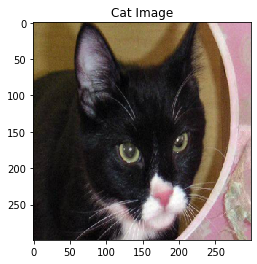

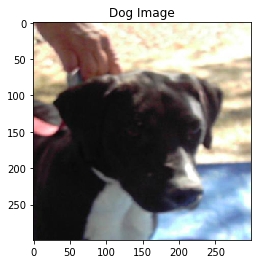

In [11]:
# stores the array of image names in the train folder
# data folder. There are a lot of images and each image
# once reshaped to 299 x 299 x 3 requires 268,203 integers
# to store. This is far too much data to fit in RAM, since
# python tends to try to save everything to RAM, it will
# crash when you try to store all of the images in an array
# or list. So we will just keep track of the image names and
# sample small subsets of the entire training set at any given
# time.
datapath = 'Cat versus dogs/train/train';
fileList = os.listdir(datapath);
cats = [];
dogs = [];
# initializes empty lists to hold the cat and dog image names
for name in fileList:
    if 'cat' in name:
        cats.append(name);
    elif 'dog' in name:
        dogs.append(name);

# Stores a list of the first 6000 cat and 6000 dog names in 
# one list we call train. This is the list of training image
# names
train = np.concatenate((cats[:6000],dogs[:6000]));
# Stores the remaining images in a list we call evaluation. This
# is the set of images we will sample from to get our evaluation
# images.
evaluation = np.concatenate((cats[6000:],dogs[6000:]));

# Returns a list of image objects given a list of image names,
# an integer indicating the size of the images (which will be 
# reshaped to be square images) and integer indicating the number
# of color channels, and a string path that tells us where to 
# find the image files.
def get_images(imageFiles,size,channels,path):
    # For the purpose of being consistent with our
    # kernel functions, we will store our images
    imageList = [];
    for image in imageFiles:
        img = Image.open(path+'/'+image);
        img = img.resize((size,size));
        imageList.append(img);
    return imageList;
# Lets load some images and display them
# first some (20) cat images
cat_images = get_images(cats[:20],size,channels,datapath);
# and some (20) dog images
dog_images = get_images(dogs[:20],size,channels,datapath);
# Lets look at the 7th cat image and the 13th dog image
plt.figure();
plt.imshow(cat_images[6]);
plt.title("Cat Image");
plt.show();
plt.figure();
plt.imshow(dog_images[12]);
plt.title("Dog Image");
plt.show();

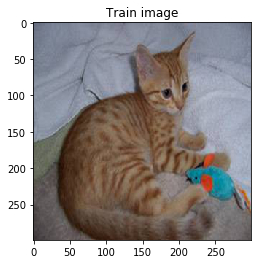

In [12]:
# Lets sample 300 image names from the train set list, and
# 300 image names from the evaluation set list. random.sample
# requires a tuple as an input, not a list, but returns a 
# list as output (go figure). random.sample samples without 
# replacement. Run this multiple times to see randomly selected
# cat and dog pictures. This may take some time to run do the the
# large size of the images.
numTrainingImages = 100;
numValidationImages = 100;
miniTrain = random.sample(tuple(train),numTrainingImages);
miniEvaluate = random.sample(tuple(evaluation),numValidationImages);
miniTrainImages = get_images(miniTrain,size,channels,datapath);
miniEvaluateImages = get_images(miniEvaluate,size,channels,datapath);
plt.figure();
plt.imshow(miniTrainImages[0]);
plt.title("Train image");
plt.show();

In [13]:
# Now we are ready to make our train and evaluation data matrices
# this function takes a list of n images and returns an n x m data 
# matrix where m = total number of pixels in the images.
def get_data_matrix(imageList):
    # assumes all images are the same shape, and computes the
    # total number of pixels based on the first image. Here
    # we also assume the image has a width, height, and channel
    # dimension.
    totalNumPixels = np.shape(imageList[0])[0]*np.shape(imageList[0])[1]*np.shape(imageList[0])[2];
    X = np.zeros((len(imageList),totalNumPixels));
    i = 0;
    for image in imageList:
        X[i,:] = np.array(image).reshape(totalNumPixels);
        i += 1;
    return X;

In [14]:
x_train = get_data_matrix(miniTrainImages)
x_evaluation = get_data_matrix(miniEvaluateImages);

In [15]:
# Uses the miniTrain and miniEvaluate filename list to
# determine the labels of each of the images in the miniTrain
# and miniEvaluate sets and to create the label vectors.
y_train = np.zeros(len(miniTrain));
y_evaluate = np.zeros(len(miniEvaluate));
# Cats are 0 and dogs are 1
for i in range(0,len(y_train)):
    if 'dog' in miniTrain[i]:
        y_train[i] = 1
for i in range(0,len(y_evaluate)):
    if 'dog' in miniEvaluate[i]:
        y_evaluate[i] = 1

In [16]:
# Now we are ready to compute the classifier
# If the k7v kernel is used, this will take some
# time, we need to pass all images through the
# 80 million or so parameter networks to get our features
n = len(y_train);
# number of dogs
n_p = np.sum(y_train);
n_m = n-n_p; # number of cats
print(n);
print(n_m);
print(n_p);
K = k(x_train,x_train); # Should be an n by n gram matrix
print(np.shape(K));
# It can be shown that the sum terms in our calculation of
# b can be computed efficiently by using 
# y_train^T K y_train, and (1-y_train)^T K (1-y_train)
K_p_sum = np.dot(y_train,np.dot(K,y_train));
K_m_sum = np.dot(1-y_train,np.dot(K,1-y_train));
b = (K_m_sum/(n_m*n_m)-K_p_sum/(n_p*n_p))/2;
# alpha is given by alpha_i = 1/n_p if y_train_i = 1 and
# alpha_i = -1/n_m if y_train_i = 0
# We can compute this in one elegant formula:
alpha = y_train/n_p +(y_train-1)/n_m

100
41.0
59.0
(100, 204800)
(100, 204800)
(100, 100)


In [17]:
# empirical loss

# b is a scalar and 
# np.dot(K,alpha) is a vector but python
# automatically knows you mean to add b
# to each component of the vector
# np.dot(K,alpha). Here, K should be symmetric
y_hat = np.dot(alpha,K)+b;
# preds is 0 if y_hat < 0, 1/2 if y_hat = 0
# and 1 if y_hat > 0. (sign(x) = -1 if x < 0, 0 if x = 0
# and 1 if x > 0)
preds = (np.sign(y_hat)+1)/2
confusionMatrix = metrics.confusion_matrix(y_train,preds);
print(confusionMatrix);
error = (confusionMatrix[0,1]+confusionMatrix[1,0])/np.sum(confusionMatrix);
print("Empirical Error rate: "+str(error))

[[41  0]
 [ 0 59]]
Empirical Error rate: 0.0


In [18]:
# If we use the 7th kernel this will take some time
# to finish evaluating
# Evaluation loss, here K is not even a square matrix
# so while it did not matter befor whether we left or 
# right multiplied by alpha, here it matters. 
KVal = k(x_train,x_evaluation);

(100, 204800)
(100, 204800)


In [19]:
y_hat = np.dot(alpha,KVal)+b;
preds = (np.sign(y_hat)+1)/2
confusionMatrix = metrics.confusion_matrix(y_evaluate,preds);
print(confusionMatrix);
error = (confusionMatrix[0,1]+confusionMatrix[1,0])/np.sum(confusionMatrix);
print("Validation Error rate: "+str(error))

[[46  4]
 [ 0 50]]
Validation Error rate: 0.04


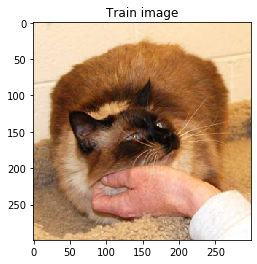

10
5.0
5.0
(10, 204800)
(10, 204800)
(10, 10)
[[5 0]
 [0 5]]
Empirical Error rate: 0.0
(10, 204800)
(100, 204800)
[[50  0]
 [ 0 50]]
Validation Error rate: 0.0


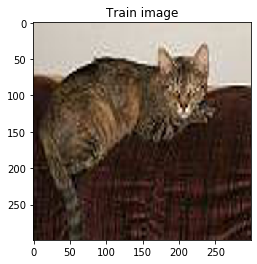

10
5.0
5.0
(10, 204800)
(10, 204800)
(10, 10)
[[5 0]
 [0 5]]
Empirical Error rate: 0.0
(10, 204800)
(100, 204800)
[[47  3]
 [ 0 50]]
Validation Error rate: 0.03


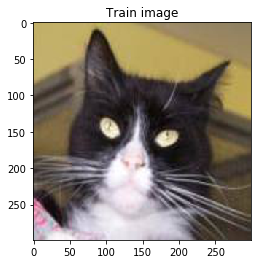

10
5.0
5.0
(10, 204800)
(10, 204800)
(10, 10)
[[5 0]
 [0 5]]
Empirical Error rate: 0.0
(10, 204800)
(100, 204800)
[[50  0]
 [ 1 49]]
Validation Error rate: 0.01


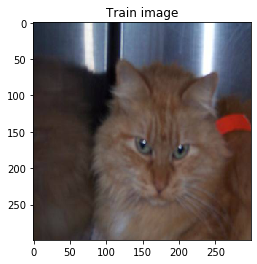

10
5.0
5.0
(10, 204800)
(10, 204800)
(10, 10)
[[5 0]
 [0 5]]
Empirical Error rate: 0.0
(10, 204800)
(100, 204800)
[[50  0]
 [ 4 46]]
Validation Error rate: 0.04


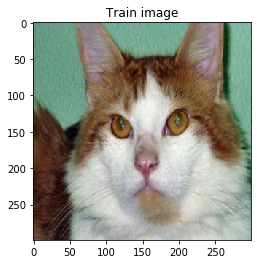

10
5.0
5.0
(10, 204800)
(10, 204800)
(10, 10)
[[5 0]
 [0 5]]
Empirical Error rate: 0.0
(10, 204800)
(100, 204800)
[[50  0]
 [ 1 49]]
Validation Error rate: 0.01


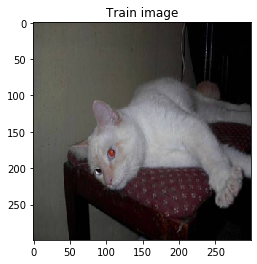

10
5.0
5.0
(10, 204800)
(10, 204800)
(10, 10)
[[5 0]
 [0 5]]
Empirical Error rate: 0.0
(10, 204800)
(100, 204800)
[[49  1]
 [ 2 48]]
Validation Error rate: 0.03


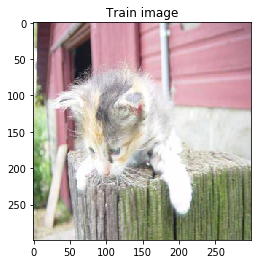

10
5.0
5.0
(10, 204800)
(10, 204800)
(10, 10)
[[5 0]
 [0 5]]
Empirical Error rate: 0.0
(10, 204800)
(100, 204800)
[[48  2]
 [ 4 46]]
Validation Error rate: 0.06


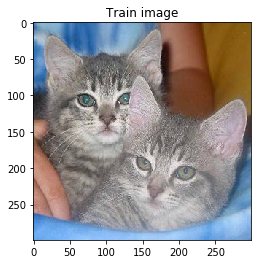

10
5.0
5.0
(10, 204800)
(10, 204800)
(10, 10)
[[5 0]
 [0 5]]
Empirical Error rate: 0.0
(10, 204800)
(100, 204800)
[[50  0]
 [ 0 50]]
Validation Error rate: 0.0


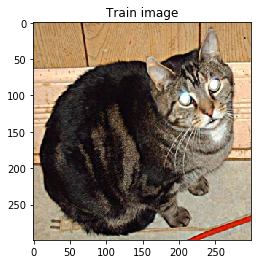

10
5.0
5.0
(10, 204800)
(10, 204800)
(10, 10)
[[5 0]
 [0 5]]
Empirical Error rate: 0.0
(10, 204800)
(100, 204800)
[[48  2]
 [ 0 50]]
Validation Error rate: 0.02


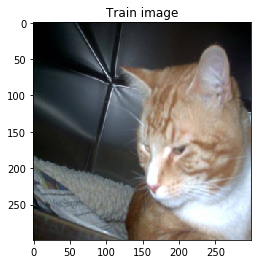

10
5.0
5.0
(10, 204800)
(10, 204800)
(10, 10)
[[5 0]
 [0 5]]
Empirical Error rate: 0.0
(10, 204800)
(100, 204800)
[[46  4]
 [ 1 49]]
Validation Error rate: 0.05


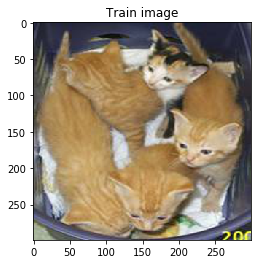

10
5.0
5.0
(10, 204800)
(10, 204800)
(10, 10)
[[5 0]
 [0 5]]
Empirical Error rate: 0.0
(10, 204800)
(100, 204800)
[[49  1]
 [ 1 49]]
Validation Error rate: 0.02


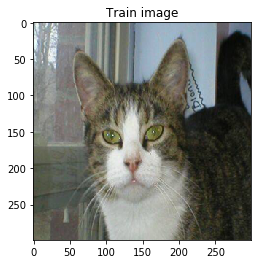

10
5.0
5.0
(10, 204800)
(10, 204800)
(10, 10)
[[5 0]
 [0 5]]
Empirical Error rate: 0.0
(10, 204800)
(100, 204800)
[[48  2]
 [ 3 47]]
Validation Error rate: 0.05


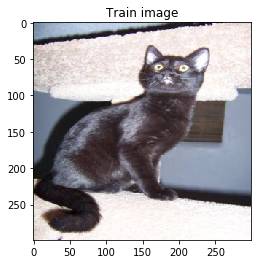

10
5.0
5.0
(10, 204800)
(10, 204800)
(10, 10)
[[5 0]
 [0 5]]
Empirical Error rate: 0.0
(10, 204800)
(100, 204800)
[[50  0]
 [ 2 48]]
Validation Error rate: 0.02


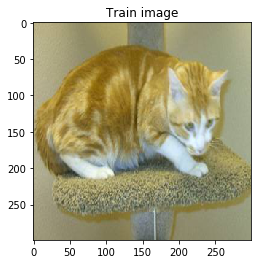

10
5.0
5.0
(10, 204800)
(10, 204800)
(10, 10)
[[5 0]
 [0 5]]
Empirical Error rate: 0.0
(10, 204800)
(100, 204800)
[[49  1]
 [ 0 50]]
Validation Error rate: 0.01


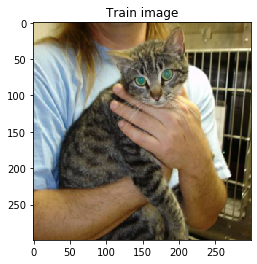

10
5.0
5.0
(10, 204800)
(10, 204800)
(10, 10)
[[5 0]
 [0 5]]
Empirical Error rate: 0.0
(10, 204800)
(100, 204800)
[[48  2]
 [ 0 50]]
Validation Error rate: 0.02


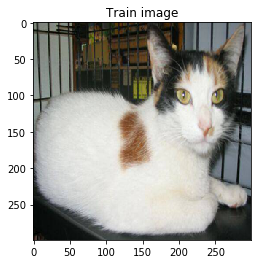

10
5.0
5.0
(10, 204800)
(10, 204800)
(10, 10)
[[5 0]
 [0 5]]
Empirical Error rate: 0.0
(10, 204800)
(100, 204800)
[[49  1]
 [ 2 48]]
Validation Error rate: 0.03


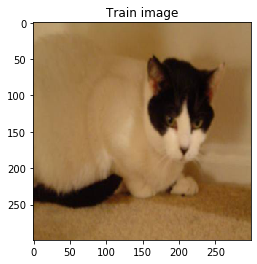

10
5.0
5.0
(10, 204800)
(10, 204800)
(10, 10)
[[5 0]
 [0 5]]
Empirical Error rate: 0.0
(10, 204800)
(100, 204800)
[[50  0]
 [ 0 50]]
Validation Error rate: 0.0


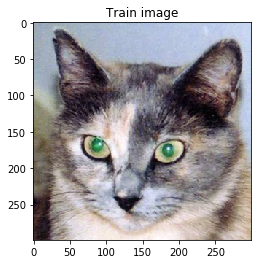

10
5.0
5.0
(10, 204800)
(10, 204800)
(10, 10)
[[5 0]
 [0 5]]
Empirical Error rate: 0.0
(10, 204800)
(100, 204800)
[[49  1]
 [ 0 50]]
Validation Error rate: 0.01


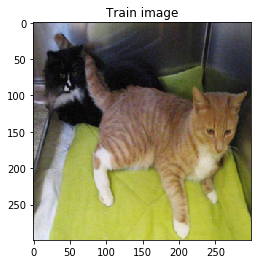

10
5.0
5.0
(10, 204800)
(10, 204800)
(10, 10)
[[5 0]
 [0 5]]
Empirical Error rate: 0.0
(10, 204800)
(100, 204800)
[[49  1]
 [ 1 49]]
Validation Error rate: 0.02


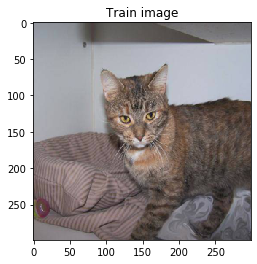

10
5.0
5.0
(10, 204800)
(10, 204800)
(10, 10)
[[5 0]
 [0 5]]
Empirical Error rate: 0.0
(10, 204800)
(100, 204800)
[[48  2]
 [ 0 50]]
Validation Error rate: 0.02


In [20]:
### Lets see how our classifier does as we run a collection
# of classifications. This will tell us the expected accuracy
# and the variance in the expected accuracies
empErrors = [];
valErrors = [];
for i in range(0,20):
    # Lets sample 50 image names from the train set list, and
    # 50 image names from the evaluation set list. random.sample
    # requires a tuple as an input, not a list, but returns a 
    # list as output (go figure). random.sample samples without 
    # replacement. Run this multiple times to see randomly selected
    # cat and dog pictures.
    numTrainingImages = 10;
    numValidationImages = 100;
    miniTrainCats = random.sample(tuple(cats[:6000]),numTrainingImages//2);
    miniTrainDogs = random.sample(tuple(dogs[:6000]),numTrainingImages//2);
    miniTrain = np.concatenate((miniTrainCats,miniTrainDogs));
    miniEvaluateCats = random.sample(tuple(cats[6000:12000]),numValidationImages//2);
    miniEvaluateDogs = random.sample(tuple(dogs[6000:12000]),numValidationImages//2);
    miniEvaluate = np.concatenate((miniEvaluateCats,miniEvaluateDogs));
    miniTrainImages = get_images(miniTrain,size,channels,datapath);
    miniEvaluateImages = get_images(miniEvaluate,size,channels,datapath);
    plt.figure();
    plt.imshow(miniTrainImages[0]);
    plt.title("Train image");
    plt.show();
    x_train = get_data_matrix(miniTrainImages)
    x_evaluation = get_data_matrix(miniEvaluateImages);
    # Uses the miniTrain and miniEvaluate filename list to
    # determine the labels of each of the images in the miniTrain
    # and miniEvaluate sets and to create the label vectors.
    y_train = np.zeros(len(miniTrain));
    y_evaluate = np.zeros(len(miniEvaluate));
    # Cats are 0 and dogs are 1
    for i in range(0,len(y_train)):
        if 'dog' in miniTrain[i]:
            y_train[i] = 1
    for i in range(0,len(y_evaluate)):
        if 'dog' in miniEvaluate[i]:
            y_evaluate[i] = 1
    # Now we are ready to compute the classifier
    # If the 7th kernel is used, this will take some
    # time, we need to pass all 500 images through the
    # 80 million or so parameter networks to get our features
    n = len(y_train);
    # number of dogs
    n_p = np.sum(y_train);
    n_m = n-n_p; # number of cats
    print(n);
    print(n_m);
    print(n_p);
    K = k(x_train,x_train); # Should be an n by n gram matrix
    print(np.shape(K));
    # It can be shown that the sum terms in our calculation of
    # b can be computed efficiently by using 
    # y_train^T K y_train, and (1-y_train)^T K (1-y_train)
    K_p_sum = np.dot(y_train,np.dot(K,y_train));
    K_m_sum = np.dot(1-y_train,np.dot(K,1-y_train));
    b = (K_m_sum/(n_m*n_m)-K_p_sum/(n_p*n_p))/2;
    # alpha is given by alpha_i = 1/n_p if y_train_i = 1 and
    # alpha_i = -1/n_m if y_train_i = 0
    # We can compute this in one elegant formula:
    alpha = y_train/n_p +(y_train-1)/n_m
    
    # empirical loss

    # b is a scalar and 
    # np.dot(K,alpha) is a vector but python
    # automatically knows you mean to add b
    # to each component of the vector
    # np.dot(K,alpha). Here, K should be symmetric
    y_hat = np.dot(alpha,K)+b;
    # preds is 0 if y_hat < 0, 1/2 if y_hat = 0
    # and 1 if y_hat > 0. (sign(x) = -1 if x < 0, 0 if x = 0
    # and 1 if x > 0)
    preds = (np.sign(y_hat)+1)/2
    confusionMatrix = metrics.confusion_matrix(y_train,preds);
    print(confusionMatrix);
    error = (confusionMatrix[0,1]+confusionMatrix[1,0])/np.sum(confusionMatrix);
    print("Empirical Error rate: "+str(error))
    empErrors.append(error);
    # If we use the 7th kernel this will take some time
    # to finish evaluating
    # Evaluation loss, here K is not even a square matrix
    # so while it did not matter befor whether we left or 
    # right multiplied by alpha, here it matters. 
    KVal = k(x_train,x_evaluation);
    y_hat = np.dot(alpha,KVal)+b;
    preds = (np.sign(y_hat)+1)/2
    confusionMatrix = metrics.confusion_matrix(y_evaluate,preds);
    print(confusionMatrix);
    error = (confusionMatrix[0,1]+confusionMatrix[1,0])/np.sum(confusionMatrix);
    print("Validation Error rate: "+str(error))
    valErrors.append(error);

In [21]:
np.mean(valErrors)

0.022500000000000003

In [22]:
np.std(valErrors)

0.016695807857064